# Assignment Transfer Learning - Fine Tuning Model

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import tensorflow as tf

import tensorflow.keras as keras
import seaborn as sns
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

## Get Data from folder

In [2]:
# get path for bird little class folder
bird_little_class_path_train = r'birds_400/little_classes/ll_train'
bird_little_class_path_val = r'birds_400/little_classes/lvl_train'

#get path for bird many class folder
bird_many_class_path_train = r'birds_400/many_classes/ml_train'
bird_many_class_path_val = r'birds_400/many_classes/mvl_train'

#get path for chest-x-array folder
chest_x_array_path_train = r'chest_xray/train'
chest_x_arry_path_val = r'chest_xray/valid'

#initialize some global variable
BATCH_SIZE = 32
IMAGE_WIDTH = IMAGE_HEIGHT = 224
Bird_Little_Numclass = 30
Bird_Many_NumClass = 100
Chest_XRay_NumClass = 2
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 70

### Visualize the data

In [3]:
class EDA_data():
    def __init__(self, path, type):
        self.data_path = path
        self.type = type
        self.data_frame = self.make_data_frame()
        
    def make_data_frame(self):
        image_path = "/**/*." + self.type
        path_images = list(glob.glob(self.data_path+image_path))
        labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_images))
        files_path = pd.Series(path_images, name="File_path").astype('str')
        labels = pd.Series(labels, name='Labels')
        data = pd.concat([files_path, labels], axis=1)
        data = data.sample(frac=1).reset_index(drop=True)
        return data

    def show_data(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(plt.imread(self.data_frame['File_path'][i]))
            ax.set_title(self.data_frame['Labels'][i])
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    def show_sample_data(self):
        plt.figure(figsize=(20,10))
        labels_count = self.data_frame['Labels'].value_counts()
        sns.barplot(x = labels_count.index, y = labels_count)
        plt.xlabel("Labels")
        plt.ylabel("# Samples")
        plt.xticks(rotation=90)

#### Visual Bird with little class

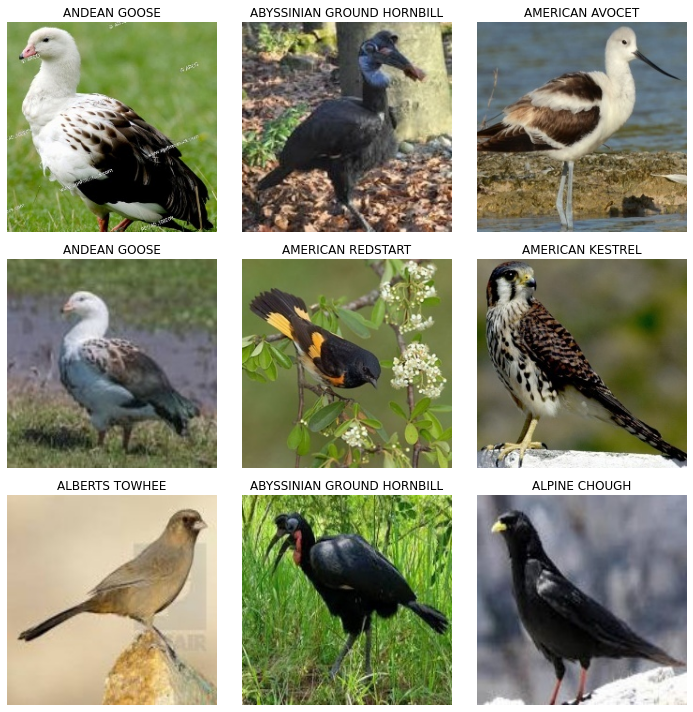

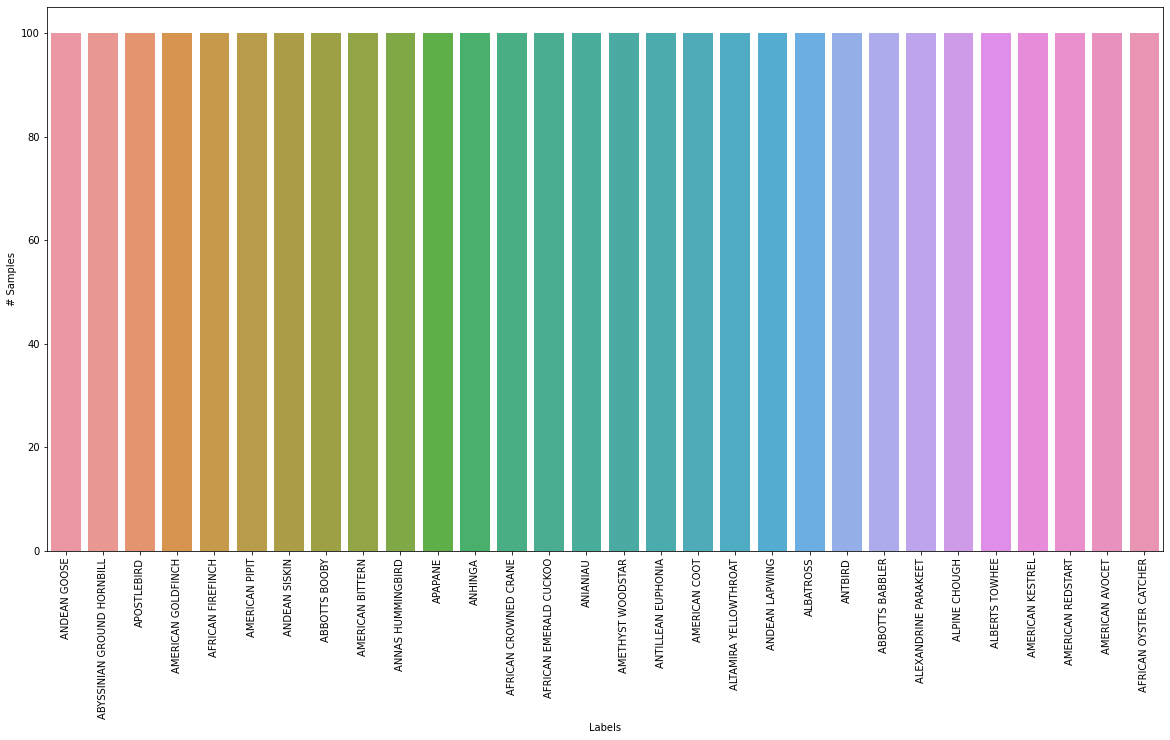

In [4]:
# visual bird with little class
bird_little_class_train = EDA_data(bird_little_class_path_train, 'jpg')
bird_little_class_train.show_data()
bird_little_class_train.show_sample_data()

#### Visual bird with many class

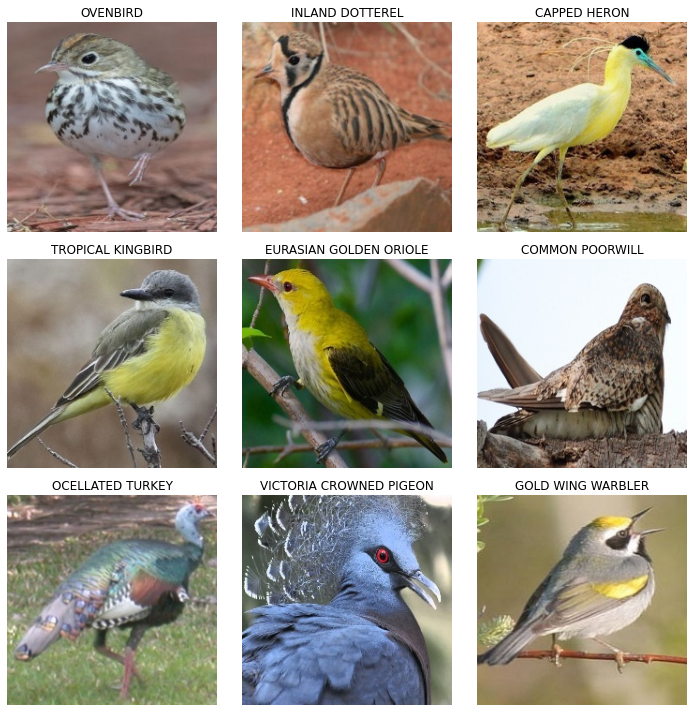

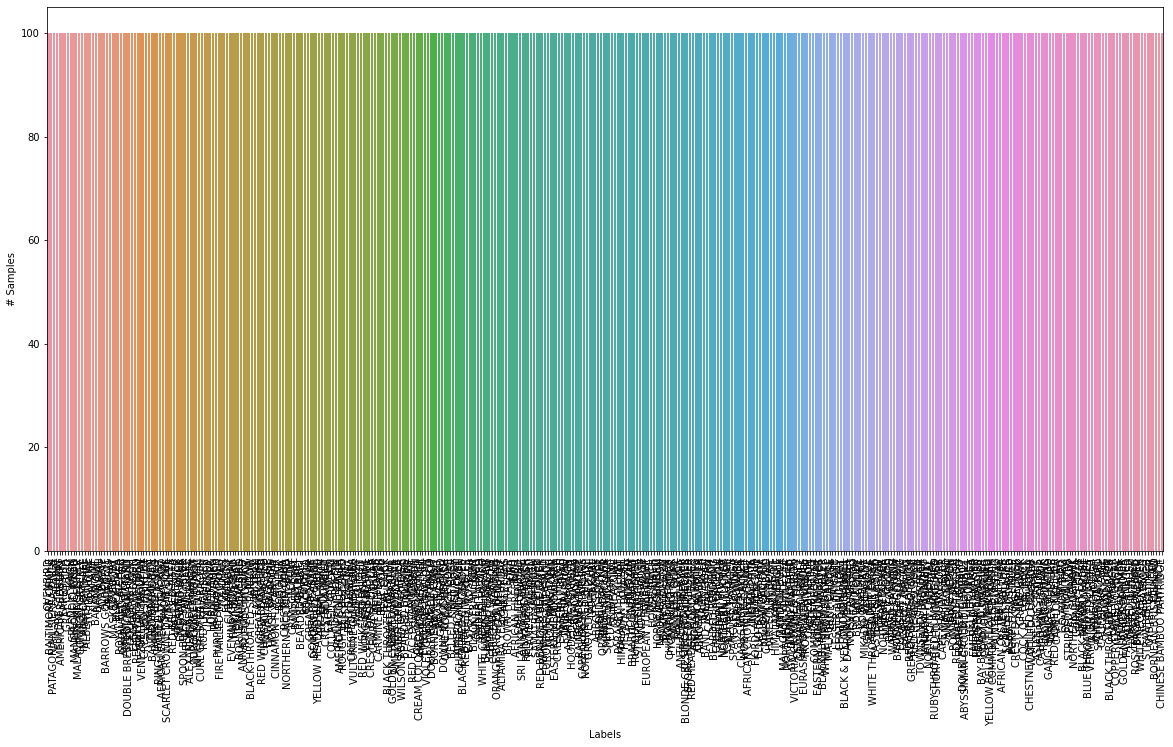

In [5]:
bird_many_class_train = EDA_data(bird_many_class_path_train, 'jpg')
bird_many_class_train.show_data()
bird_many_class_train.show_sample_data()

#### Visual chest XRay

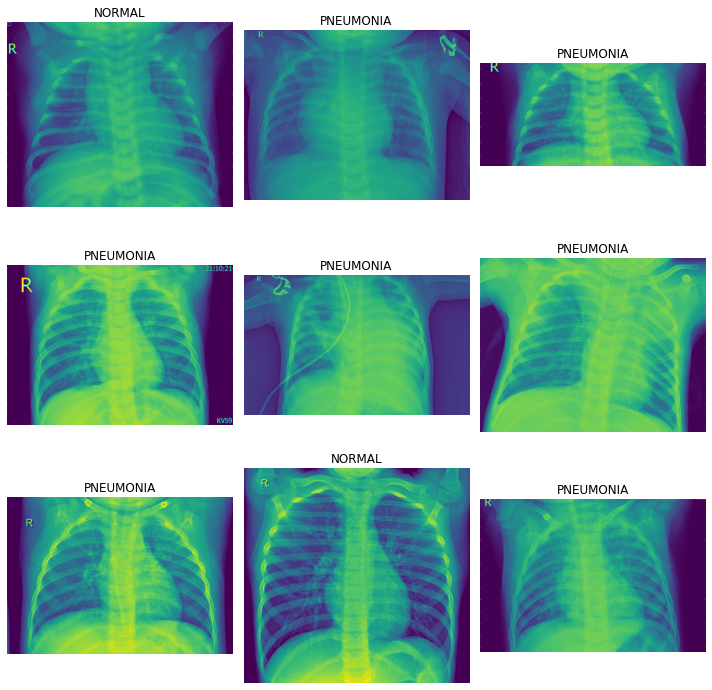

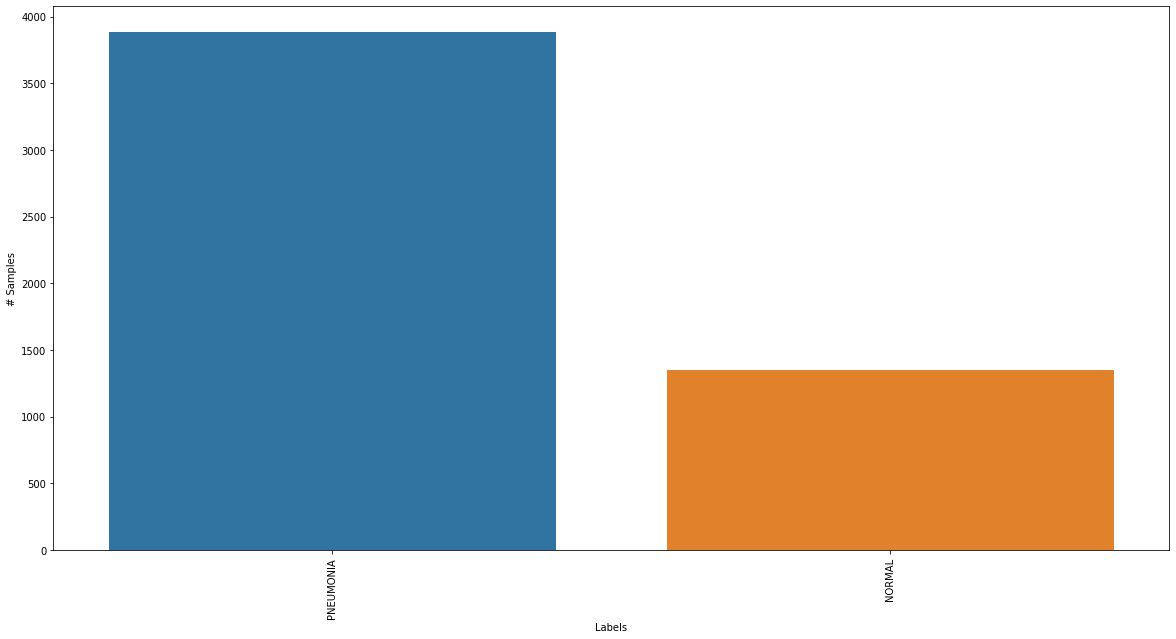

In [6]:
chest_xray_train = EDA_data(chest_x_array_path_train, 'jpeg')
chest_xray_train.show_data()
chest_xray_train.show_sample_data()

### Set the data for train and val set

In [3]:
class DataLoader():
    def __init__(self, train_path_string, val_path_string):
        self.train_ds = tf.data.Dataset.list_files(train_path_string, shuffle=True)
        self.val_ds = tf.data.Dataset.list_files(val_path_string, shuffle=True)
        self.get_class_names(train_path_string)
    
    def get_class_names(self , path):
        self.class_names = sorted(os.listdir("/".join(path.split("/")[:-2])))
        print(self.class_names)
            
    def get_label(self, file_path):
        # Convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        # The second to last is the class-directory
        one_hot = parts[-2] == self.class_names
        # Integer encode the label
        return tf.argmax(one_hot)

    def decode_img(self, img):
        # Convert the compressed string to a 3D uint8 tensor
        img = tf.io.decode_jpeg(img, channels=3)
        # Resize the image to the desired size
        return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    
    def configure_for_performance(self, ds):
        #ds = ds.cache()
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    def make_data(self):
        def process_path(file_path):
            label = self.get_label(file_path)
            # Load the raw data from the file as a string
            img = tf.io.read_file(file_path)
            img = self.decode_img(img)
            return img, label
        
        # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
        self.train_ds = self.train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
        self.val_ds = self.val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
        
        self.train_ds = self.configure_for_performance(self.train_ds)
        self.val_ds = self.configure_for_performance(self.val_ds)        

#### load Bird with little class

In [4]:
bird_little_class_train_path_string = bird_little_class_path_train+"/**/*.jpg"
bird_little_class_val_path_string = bird_little_class_path_val+"/**/*.jpg"
bird_litle_class = DataLoader(bird_little_class_train_path_string, bird_little_class_val_path_string)

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD']


2022-04-19 17:42:28.721525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 17:42:28.773708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 17:42:28.773866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 17:42:28.774593: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
bird_litle_class.make_data()

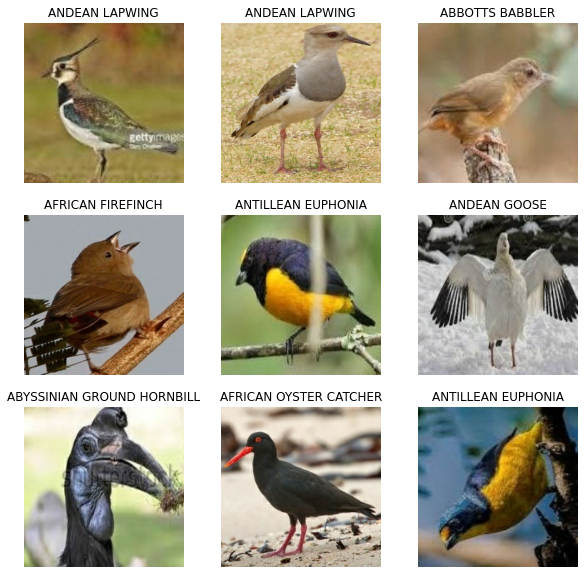

In [6]:
image_batch, label_batch = next(iter(bird_litle_class.train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(bird_litle_class.class_names[label])
  plt.axis("off")

#### Load bird with many class

In [5]:
bird_many_class_train_path_string = bird_many_class_path_train+"/**/*.jpg"
bird_many_class_val_path_string = bird_many_class_path_val+"/**/*.jpg"
bird_many_class = DataLoader(bird_many_class_train_path_string, bird_many_class_val_path_string)

2022-04-14 19:31:55.074135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 19:31:55.128256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 19:31:55.128414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 19:31:55.129230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'AVADAVAT', 'AZURE JAY', 'AZURE TANAGER', 'AZURE TIT', 'BAIKAL TEAL', 'BALD EAGLE', 'BALD IBIS', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BAND TAILED GUAN', 'BANDED BROADBILL', 'BANDED PITA', 'BANDED STILT', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BARROWS GOLDENEYE', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BEARDED BELLBIR

In [6]:
bird_many_class.make_data()

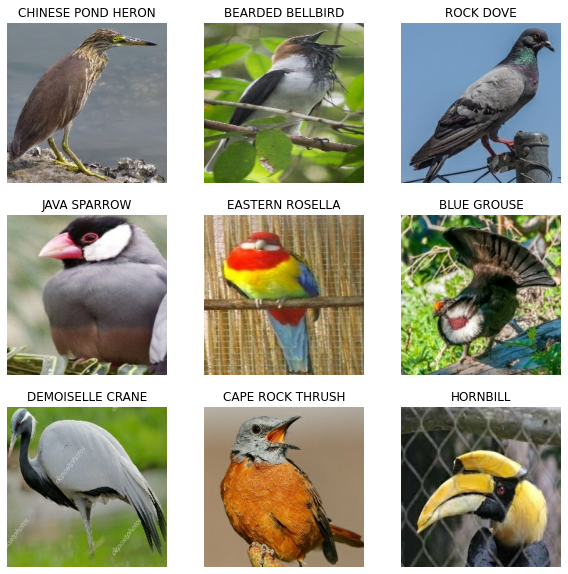

In [7]:
image_batch, label_batch = next(iter(bird_many_class.train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(bird_many_class.class_names[label])
  plt.axis("off")

#### Load Chest X-Ray

In [4]:
chest_xray_train_path_string = chest_x_array_path_train+"/**/*.jpeg"
chest_xray_val_path_string = chest_x_arry_path_val+"/**/*.jpeg"
chest_xray = DataLoader(chest_xray_train_path_string, chest_xray_val_path_string)

['NORMAL', 'PNEUMONIA']


2022-04-18 21:33:30.436465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 21:33:30.487789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 21:33:30.487946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 21:33:30.488845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
chest_xray.make_data()

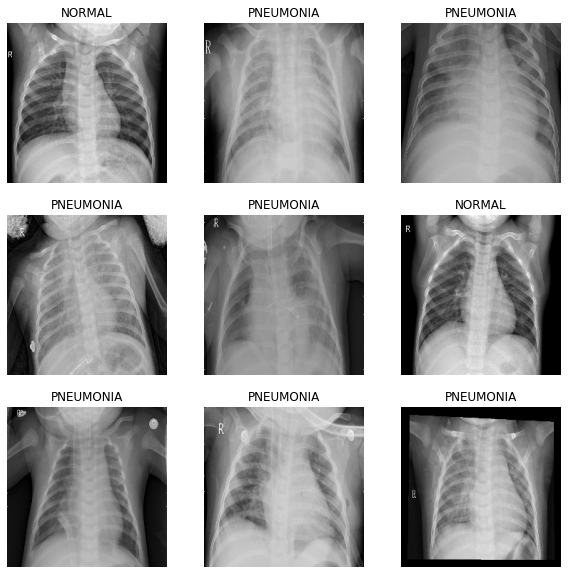

In [6]:
image_batch, label_batch = next(iter(chest_xray.train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(chest_xray.class_names[label])
  plt.axis("off")

## Build Model

In [6]:
class MobileNetV2():
    def __init__(self, fine_tuning = None, pretrain = False, Initilaize_pretrain = False):
        self.fine_tuning = fine_tuning
        self.pretrain = pretrain
        self.Initilize_pretrain = Initilaize_pretrain
    
    def create_model_MobileNetV2(self):
        model = keras.applications.MobileNetV2
        if self.fine_tuning != None:
            result = model(include_top=False, weights='imagenet')
            for layer in result.layers[:self.fine_tuning]:
                layer.trainable = False
            print('train with fine tuning')
            return result
        if self.pretrain == True:
            result = model(include_top=False, weights='imagenet')
            result.trainable = False
            print('train with pretrain model')
            return result
        if self.Initilize_pretrain == True:
            result = model(include_top=False, weights='imagenet')
            print('train with initialize_pretrain model')
            return result
        result = model(include_top=False, weights=None)
        print('train with scratch')
        return result

    

## Training

#### Data augmentation

In [7]:
def augmentation():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(tf.keras.layers.Lambda(lambda x : tf.keras.applications.vgg19.preprocess_input(x)))
  data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
  data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
  data_augmentation.add(tf.keras.layers.RandomTranslation(height_factor = (-0.1, 0.1), width_factor = (-0.1, 0.1), fill_mode='nearest'))
  return data_augmentation       

### Train Model With Bird little class - 30 classes

#### Train From Scratch

In [12]:
MobileNetV2_little_bird_class_scratch = MobileNetV2()
MobileNetV2_little_bird_model_scratch = MobileNetV2_little_bird_class_scratch.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = tf.keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_little_bird_model_scratch(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 30, activation= 'softmax')(x)
Bird_little_Class_Classification_scratch = keras.Model(inputs = image_input, outputs = outputs)
Bird_little_Class_Classification_scratch.summary()


train with scratch
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_None (Func  (None, None, None, 1280)  2257984  
 tional)                                                         
                                        

In [13]:
Bird_little_Class_Classification_scratch.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [15]:
checkpoint_path = "little_bird_class_scratch.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
history_Bird_little_Class_Classification_scratch = Bird_little_Class_Classification_scratch.fit(bird_litle_class.train_ds,
                                epochs = EPOCHS,
                                validation_data = bird_litle_class.val_ds,
                                callbacks=[model_checkpoint, learning_rate_reduction])

Epoch 1/70
94/94 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.8690
Epoch 00001: val_accuracy improved from -inf to 0.26222, saving model to little_bird_class_scratch.ckpt
94/94 [==============================] - 17s 176ms/step - loss: 0.4327 - accuracy: 0.8690 - val_loss: 2.7400 - val_accuracy: 0.2622 - lr: 1.0000e-05
Epoch 2/70
94/94 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.8787
Epoch 00002: val_accuracy improved from 0.26222 to 0.31444, saving model to little_bird_class_scratch.ckpt
94/94 [==============================] - 17s 180ms/step - loss: 0.4114 - accuracy: 0.8787 - val_loss: 2.5211 - val_accuracy: 0.3144 - lr: 1.0000e-05
Epoch 3/70
94/94 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8717
Epoch 00003: val_accuracy improved from 0.31444 to 0.38222, saving model to little_bird_class_scratch.ckpt
94/94 [==============================] - 17s 178ms/step - loss: 0.4287 - accuracy: 0.8717 - val_loss: 

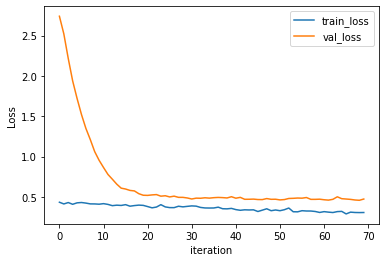

In [16]:
import matplotlib.pyplot as plt

plt.plot(history_Bird_little_Class_Classification_scratch.history['loss'], label = "train_loss")
plt.plot(history_Bird_little_Class_Classification_scratch.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

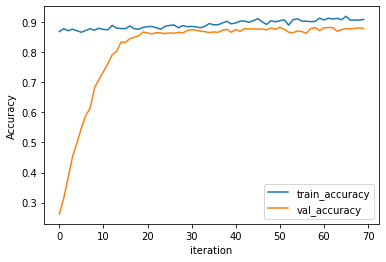

In [17]:
import matplotlib.pyplot as plt

plt.plot(history_Bird_little_Class_Classification_scratch.history['accuracy'], label = "train_accuracy")
plt.plot(history_Bird_little_Class_Classification_scratch.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train with Fine tuning

In [38]:
MobileNetV2_class_fine_tuning = MobileNetV2(fine_tuning=140)
MobileNetV2_model_fine_tuning = MobileNetV2_class_fine_tuning.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_model_fine_tuning(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 30, activation= 'softmax')(x)
Bird_Little_Class_Classification_fine_tuning = keras.Model(inputs = image_input, outputs = outputs)
Bird_Little_Class_Classification_fine_tuning.summary()

train with fine tuning
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                    

In [39]:
Bird_Little_Class_Classification_fine_tuning.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [40]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience = 5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
checkpoint_path = "little_bird_class_fine_tuning.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
    
history_bird_little_class_fine_tuning = Bird_Little_Class_Classification_fine_tuning.fit(bird_litle_class.train_ds,
                                epochs = EPOCHS,
                                validation_data = bird_litle_class.val_ds,
                                callbacks=[model_checkpoint, learning_rate_reduction])

Epoch 1/70
94/94 [==============================] - ETA: 0s - loss: 3.0174 - accuracy: 0.4020
Epoch 00001: val_accuracy improved from -inf to 0.18000, saving model to little_bird_class_fine_tuning.ckpt
94/94 [==============================] - 7s 55ms/step - loss: 3.0174 - accuracy: 0.4020 - val_loss: 6.5160 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 2/70
93/94 [============================>.] - ETA: 0s - loss: 1.2692 - accuracy: 0.6573
Epoch 00002: val_accuracy improved from 0.18000 to 0.34778, saving model to little_bird_class_fine_tuning.ckpt
94/94 [==============================] - 5s 52ms/step - loss: 1.2754 - accuracy: 0.6563 - val_loss: 4.2974 - val_accuracy: 0.3478 - lr: 0.0010
Epoch 3/70
93/94 [============================>.] - ETA: 0s - loss: 1.0990 - accuracy: 0.7077
Epoch 00003: val_accuracy did not improve from 0.34778
94/94 [==============================] - 5s 51ms/step - loss: 1.0970 - accuracy: 0.7080 - val_loss: 6.2893 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 4/70
93/9

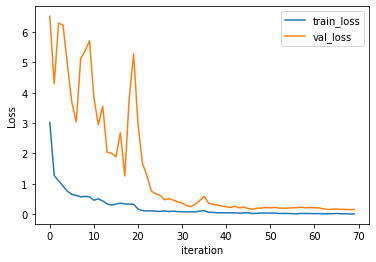

In [41]:
import matplotlib.pyplot as plt

plt.plot(history_bird_little_class_fine_tuning.history['loss'], label = "train_loss")
plt.plot(history_bird_little_class_fine_tuning.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

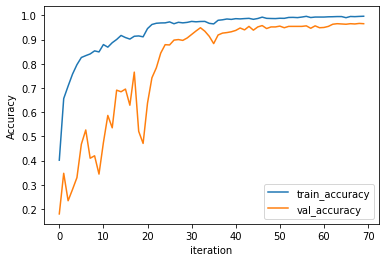

In [42]:
import matplotlib.pyplot as plt

plt.plot(history_bird_little_class_fine_tuning.history['accuracy'], label = "train_accuracy")
plt.plot(history_bird_little_class_fine_tuning.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train with pretrain model

In [43]:
MobileNetV2_class_pretrain = MobileNetV2(pretrain=True)
MobileNetV2_model_pretrain = MobileNetV2_class_pretrain.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_model_pretrain(x)
x = layers.GlobalMaxPool2D()(x)
x = layers.Dense(units=1024, activation='relu')(x)
outputs= layers.Dense(units = 30, activation= 'softmax')(x)
Bird_Little_Class_Classification_pretrain = keras.Model(inputs = image_input, outputs = outputs)
Bird_Little_Class_Classification_pretrain.summary()

train with pretrain model
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                 

In [44]:
Bird_Little_Class_Classification_pretrain.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [45]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience = 5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

checkpoint_path = "little_bird_class_pretrain.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)

history_bird_little_class_pretrain = Bird_Little_Class_Classification_pretrain.fit(bird_litle_class.train_ds,
                                epochs = EPOCHS,
                                validation_data = bird_litle_class.val_ds,
                                callbacks=[model_checkpoint, learning_rate_reduction])

Epoch 1/70
93/94 [============================>.] - ETA: 0s - loss: 5.3973 - accuracy: 0.2584
Epoch 00001: val_accuracy improved from -inf to 0.47333, saving model to little_bird_class_fine_tuning.ckpt
94/94 [==============================] - 6s 53ms/step - loss: 5.3745 - accuracy: 0.2593 - val_loss: 1.8353 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 2/70
93/94 [============================>.] - ETA: 0s - loss: 1.6872 - accuracy: 0.5027
Epoch 00002: val_accuracy improved from 0.47333 to 0.63889, saving model to little_bird_class_fine_tuning.ckpt
94/94 [==============================] - 5s 49ms/step - loss: 1.6804 - accuracy: 0.5053 - val_loss: 1.1962 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 3/70
93/94 [============================>.] - ETA: 0s - loss: 1.4060 - accuracy: 0.5716
Epoch 00003: val_accuracy improved from 0.63889 to 0.66444, saving model to little_bird_class_fine_tuning.ckpt
94/94 [==============================] - 5s 50ms/step - loss: 1.4048 - accuracy: 0.5713 - val_loss: 1.

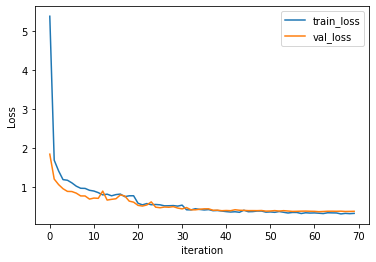

In [46]:
import matplotlib.pyplot as plt

plt.plot(history_bird_little_class_pretrain.history['loss'], label = "train_loss")
plt.plot(history_bird_little_class_pretrain.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

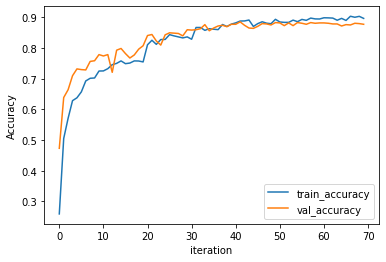

In [47]:
import matplotlib.pyplot as plt

plt.plot(history_bird_little_class_pretrain.history['accuracy'], label = "train_accuracy")
plt.plot(history_bird_little_class_pretrain.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train with initialize model

In [56]:
MobileNetV2_class_initialize = MobileNetV2(Initilaize_pretrain=True)
MobileNetV2_model_initialize = MobileNetV2_class_initialize.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_model_initialize(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 30, activation= 'softmax')(x)
Bird_Little_Class_Classification_initialize = keras.Model(inputs = image_input, outputs = outputs)
Bird_Little_Class_Classification_initialize.summary()

train with initialize_pretrain model
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                     

In [57]:
Bird_Little_Class_Classification_initialize.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [58]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience = 5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
checkpoint_path = "little_bird_class_initialize.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
history_bird_little_class_initialize = Bird_Little_Class_Classification_initialize.fit(bird_litle_class.train_ds,
                                epochs = EPOCHS,
                                validation_data = bird_litle_class.val_ds,
                                callbacks=[model_checkpoint, learning_rate_reduction])

Epoch 1/70
94/94 [==============================] - ETA: 0s - loss: 2.7558 - accuracy: 0.4670
Epoch 00001: val_accuracy improved from -inf to 0.09333, saving model to little_bird_class_initialize.ckpt
94/94 [==============================] - 19s 179ms/step - loss: 2.7558 - accuracy: 0.4670 - val_loss: 10.4168 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 2/70
94/94 [==============================] - ETA: 0s - loss: 1.0696 - accuracy: 0.7040
Epoch 00002: val_accuracy improved from 0.09333 to 0.13444, saving model to little_bird_class_initialize.ckpt
94/94 [==============================] - 17s 176ms/step - loss: 1.0696 - accuracy: 0.7040 - val_loss: 7.0049 - val_accuracy: 0.1344 - lr: 0.0010
Epoch 3/70
94/94 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.7707
Epoch 00003: val_accuracy improved from 0.13444 to 0.20889, saving model to little_bird_class_initialize.ckpt
94/94 [==============================] - 17s 179ms/step - loss: 0.8337 - accuracy: 0.7707 - val_loss

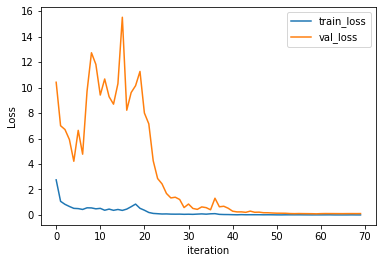

In [59]:
import matplotlib.pyplot as plt

plt.plot(history_bird_little_class_initialize.history['loss'], label = "train_loss")
plt.plot(history_bird_little_class_initialize.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

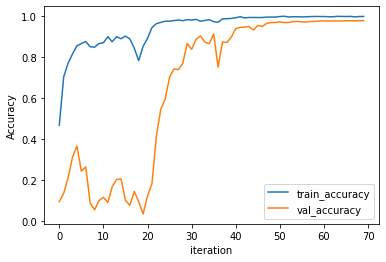

In [60]:
import matplotlib.pyplot as plt

plt.plot(history_bird_little_class_initialize.history['accuracy'], label = "train_accuracy")
plt.plot(history_bird_little_class_initialize.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

### Train model with many class - 400 class

#### Train Model With Scratch

In [66]:
MobileNetV2_many_bird_class_scratch = MobileNetV2()
MobileNetV2_many_bird_model_scratch = MobileNetV2_many_bird_class_scratch.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = tf.keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_many_bird_model_scratch(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 400, activation= 'softmax')(x)
Bird_Many_Class_Classification_scratch = keras.Model(inputs = image_input, outputs = outputs)
Bird_Many_Class_Classification_scratch.summary()

train with scratch
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_None (Func  (None, None, None, 1280)  2257984  
 tional)                                                         
                                       

In [67]:
Bird_Many_Class_Classification_scratch.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [68]:
checkpoint_path = "many_bird_class_scratch.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
    
history_bird_many_class_scratch = Bird_Many_Class_Classification_scratch.fit(bird_many_class.train_ds  ,
                                epochs = EPOCHS,
                                validation_data = bird_many_class.val_ds,
                                callbacks = [model_checkpoint])

Epoch 1/70
1250/1250 [==============================] - ETA: 0s - loss: 6.6810 - accuracy: 0.0031
Epoch 00001: val_accuracy improved from -inf to 0.00250, saving model to many_bird_class_scratch.ckpt
1250/1250 [==============================] - 225s 178ms/step - loss: 6.6810 - accuracy: 0.0031 - val_loss: 6.0120 - val_accuracy: 0.0025
Epoch 2/70
1250/1250 [==============================] - ETA: 0s - loss: 5.7805 - accuracy: 0.0113
Epoch 00002: val_accuracy did not improve from 0.00250
1250/1250 [==============================] - 224s 179ms/step - loss: 5.7805 - accuracy: 0.0113 - val_loss: 6.0613 - val_accuracy: 0.0025
Epoch 3/70
1250/1250 [==============================] - ETA: 0s - loss: 4.8746 - accuracy: 0.0497
Epoch 00003: val_accuracy did not improve from 0.00250
1250/1250 [==============================] - 222s 178ms/step - loss: 4.8746 - accuracy: 0.0497 - val_loss: 6.6834 - val_accuracy: 0.0025
Epoch 4/70
1250/1250 [==============================] - ETA: 0s - loss: 3.9772 - ac

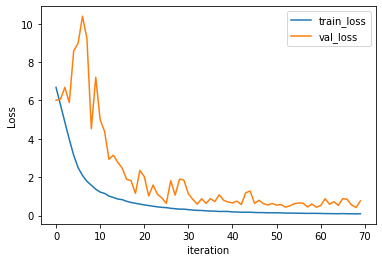

In [69]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_scratch.history['loss'], label = "train_loss")
plt.plot(history_bird_many_class_scratch.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

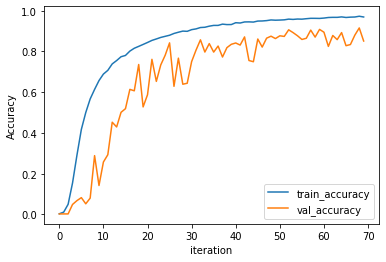

In [70]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_scratch.history['accuracy'], label = "train_accuracy")
plt.plot(history_bird_many_class_scratch.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train with fine tuning

In [85]:
MobileNetV2_bird_many_class_finetuning= MobileNetV2(fine_tuning=140)
MobileNetV2_bird_many_model_finetuning = MobileNetV2_bird_many_class_finetuning.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_bird_many_model_finetuning(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 400, activation= 'softmax')(x)
Bird_Many_Class_Classification_finetuning = keras.Model(inputs = image_input, outputs = outputs)
Bird_Many_Class_Classification_finetuning.summary()

train with fine tuning
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_17 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_17 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_max_pooling2d_19 (Gl  (None, 1280)             0         
 obalMaxPooling2D)                 

In [86]:
Bird_Many_Class_Classification_finetuning.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [87]:
checkpoint_path = "many_bird_class_fine_tuning.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)

history_bird_many_class_finetuning = Bird_Many_Class_Classification_finetuning.fit(bird_many_class.train_ds,
                                epochs = EPOCHS,
                                validation_data = bird_many_class.val_ds,
                                callbacks = [model_checkpoint])

Epoch 1/70
1250/1250 [==============================] - ETA: 0s - loss: 2.6094 - accuracy: 0.4764
Epoch 00001: val_accuracy improved from -inf to 0.19883, saving model to many_bird_class_fine_tuning.ckpt
1250/1250 [==============================] - 62s 49ms/step - loss: 2.6094 - accuracy: 0.4764 - val_loss: 6.8490 - val_accuracy: 0.1988
Epoch 2/70
1249/1250 [============================>.] - ETA: 0s - loss: 0.7211 - accuracy: 0.8054
Epoch 00002: val_accuracy improved from 0.19883 to 0.47317, saving model to many_bird_class_fine_tuning.ckpt
1250/1250 [==============================] - 61s 49ms/step - loss: 0.7214 - accuracy: 0.8054 - val_loss: 3.5338 - val_accuracy: 0.4732
Epoch 3/70
1249/1250 [============================>.] - ETA: 0s - loss: 0.4641 - accuracy: 0.8707
Epoch 00003: val_accuracy improved from 0.47317 to 0.75933, saving model to many_bird_class_fine_tuning.ckpt
1250/1250 [==============================] - 61s 48ms/step - loss: 0.4640 - accuracy: 0.8707 - val_loss: 1.0832 

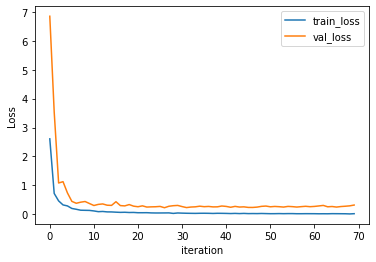

In [88]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_finetuning.history['loss'], label = "train_loss")
plt.plot(history_bird_many_class_finetuning.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

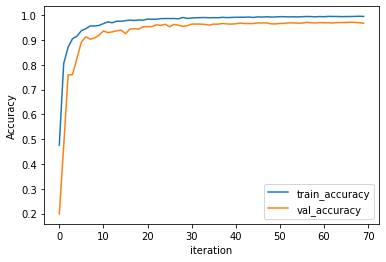

In [89]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_finetuning.history['accuracy'], label = "train_accuracy")
plt.plot(history_bird_many_class_finetuning.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train with pretrain model

In [96]:
MobileNetV2_bird_many_class_pretrain= MobileNetV2(pretrain=True)
MobileNetV2_bird_many_model_pretrain = MobileNetV2_bird_many_class_pretrain.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_bird_many_model_pretrain(x)
x = layers.GlobalMaxPool2D()(x)
x = layers.Dense(units=1024, activation='relu')(x)
outputs= layers.Dense(units = 400, activation= 'softmax')(x)
Bird_Many_Class_Classification_pretrain = keras.Model(inputs = image_input, outputs = outputs)
Bird_Many_Class_Classification_pretrain.summary()

train with pretrain model
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_19 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_19 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                

In [97]:
Bird_Many_Class_Classification_pretrain.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [98]:
checkpoint_path = "many_bird_class_pretrain.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
history_bird_many_class_pretrain = Bird_Many_Class_Classification_pretrain.fit(bird_many_class.train_ds,
                                epochs = EPOCHS,
                                validation_data = bird_many_class.val_ds,
                                callbacks = [model_checkpoint])

Epoch 1/70
1249/1250 [============================>.] - ETA: 0s - loss: 5.6955 - accuracy: 0.0125
Epoch 00001: val_accuracy improved from -inf to 0.02408, saving model to many_bird_class_pretrain.ckpt
1250/1250 [==============================] - 62s 49ms/step - loss: 5.6951 - accuracy: 0.0125 - val_loss: 5.0581 - val_accuracy: 0.0241
Epoch 2/70
1249/1250 [============================>.] - ETA: 0s - loss: 5.0572 - accuracy: 0.0227
Epoch 00002: val_accuracy improved from 0.02408 to 0.02900, saving model to many_bird_class_pretrain.ckpt
1250/1250 [==============================] - 61s 49ms/step - loss: 5.0571 - accuracy: 0.0227 - val_loss: 4.8446 - val_accuracy: 0.0290
Epoch 3/70
1249/1250 [============================>.] - ETA: 0s - loss: 4.9663 - accuracy: 0.0287
Epoch 00003: val_accuracy improved from 0.02900 to 0.03325, saving model to many_bird_class_pretrain.ckpt
1250/1250 [==============================] - 61s 49ms/step - loss: 4.9665 - accuracy: 0.0287 - val_loss: 4.7906 - val_acc

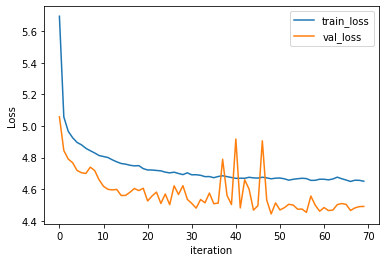

In [100]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_pretrain.history['loss'], label = "train_loss")
plt.plot(history_bird_many_class_pretrain.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

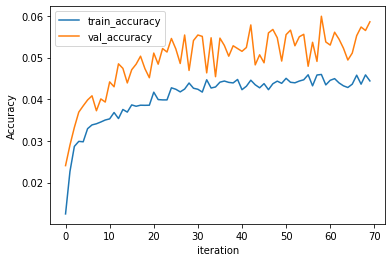

In [101]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_pretrain.history['accuracy'], label = "train_accuracy")
plt.plot(history_bird_many_class_pretrain.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train with initialize pretrain

In [103]:
MobileNetV2_bird_many_class_initilaize= MobileNetV2(Initilaize_pretrain=True)
MobileNetV2_bird_many_model_initilaize = MobileNetV2_bird_many_class_initilaize.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers )
x = MobileNetV2_bird_many_model_initilaize(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 400, activation= 'softmax')(x)
Bird_Many_Class_Classification_initialize = keras.Model(inputs = image_input, outputs = outputs)
Bird_Many_Class_Classification_initialize.summary()

train with initialize_pretrain model
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_14 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_21 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_21 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                     

In [104]:
Bird_Many_Class_Classification_initialize.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [105]:
checkpoint_path = "many_bird_class_initialize.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
history_bird_many_class_initialize = Bird_Many_Class_Classification_initialize.fit(bird_many_class.train_ds,
                                epochs = EPOCHS,
                                validation_data = bird_many_class.val_ds, 
                                callbacks=[model_checkpoint])

Epoch 1/70
1250/1250 [==============================] - ETA: 0s - loss: 6.2697 - accuracy: 0.0044
Epoch 00001: val_accuracy improved from -inf to 0.00250, saving model to many_bird_class_initialize.ckpt
1250/1250 [==============================] - 224s 178ms/step - loss: 6.2697 - accuracy: 0.0044 - val_loss: 14.7266 - val_accuracy: 0.0025
Epoch 2/70
1250/1250 [==============================] - ETA: 0s - loss: 6.0254 - accuracy: 0.0062
Epoch 00002: val_accuracy did not improve from 0.00250
1250/1250 [==============================] - 220s 176ms/step - loss: 6.0254 - accuracy: 0.0062 - val_loss: 7.1267 - val_accuracy: 0.0025
Epoch 3/70
1250/1250 [==============================] - ETA: 0s - loss: 5.7825 - accuracy: 0.0104
Epoch 00003: val_accuracy did not improve from 0.00250
1250/1250 [==============================] - 223s 178ms/step - loss: 5.7825 - accuracy: 0.0104 - val_loss: 7.0061 - val_accuracy: 0.0023
Epoch 4/70
1250/1250 [==============================] - ETA: 0s - loss: 5.5283 

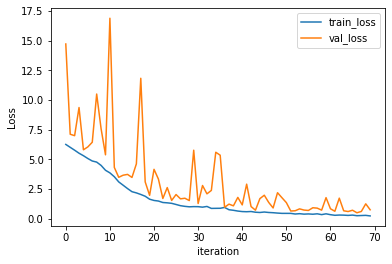

In [106]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_initialize.history['loss'], label = "train_loss")
plt.plot(history_bird_many_class_initialize.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

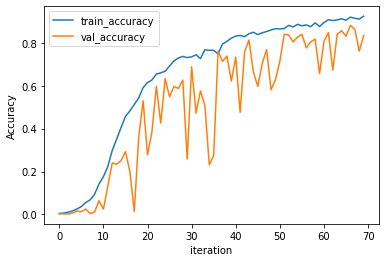

In [107]:
import matplotlib.pyplot as plt

plt.plot(history_bird_many_class_initialize.history['accuracy'], label = "train_accuracy")
plt.plot(history_bird_many_class_initialize.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

### Train Model With chest_xaray

#### Train From Scratch

In [14]:
MobileNetV2_Chest_Xaray_Scratch= MobileNetV2()
MobileNetV2_Chest_Xaray_model_Scratch = MobileNetV2_Chest_Xaray_Scratch.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_Chest_Xaray_model_Scratch(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 2, activation= 'softmax')(x)
Chest_Xaray_Classification_Scratch = keras.Model(inputs = image_input, outputs = outputs)
Chest_Xaray_Classification_Scratch.summary()

train with scratch
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_None (Func  (None, None, None, 1280)  2257984  
 tional)                                                         
                                        

In [16]:
Chest_Xaray_Classification_Scratch.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [17]:
checkpoint_path = "Chest_Xaray_Classification_Scratch.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
    
history_Chest_Xaray_Classification_Scratch = Chest_Xaray_Classification_Scratch.fit(chest_xray.train_ds,
                                epochs = EPOCHS,
                                validation_data = chest_xray.val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/70


2022-04-18 21:44:20.530738: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-04-18 21:44:21.121629: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


164/164 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.8152
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to Chest_Xaray_Classification_Scratch.ckpt
164/164 [==============================] - 35s 180ms/step - loss: 0.5110 - accuracy: 0.8152 - val_loss: 0.6924 - val_accuracy: 0.6250
Epoch 2/70
164/164 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8448
Epoch 00002: val_accuracy did not improve from 0.62500
164/164 [==============================] - 30s 176ms/step - loss: 0.4195 - accuracy: 0.8448 - val_loss: 0.6927 - val_accuracy: 0.6250
Epoch 3/70
164/164 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.8817
Epoch 00003: val_accuracy did not improve from 0.62500
164/164 [==============================] - 30s 181ms/step - loss: 0.2994 - accuracy: 0.8817 - val_loss: 0.6762 - val_accuracy: 0.6250
Epoch 4/70
164/164 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9018
Ep

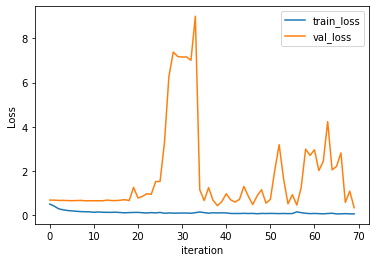

In [18]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Scratch.history['loss'], label = "train_loss")
plt.plot(history_Chest_Xaray_Classification_Scratch.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

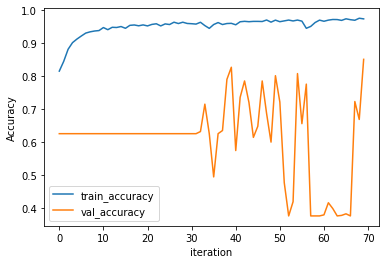

In [19]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Scratch.history['accuracy'], label = "train_accuracy")
plt.plot(history_Chest_Xaray_Classification_Scratch.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train Model With Fine tuning

In [20]:
MobileNetV2_Chest_Xaray_Fine_Tuning= MobileNetV2(fine_tuning=140)
MobileNetV2_Chest_Xaray_model_Fine_Tuning = MobileNetV2_Chest_Xaray_Fine_Tuning.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_Chest_Xaray_model_Fine_Tuning(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 2, activation= 'softmax')(x)
Chest_Xaray_Classification_Fine_Tuning = keras.Model(inputs = image_input, outputs = outputs)
Chest_Xaray_Classification_Fine_Tuning.summary()

train with fine tuning
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                    

In [21]:
Chest_Xaray_Classification_Fine_Tuning.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [22]:
checkpoint_path = "Chest_Xaray_Classification_Fine_Tuning.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
    
history_Chest_Xaray_Classification_Fine_Tuning = Chest_Xaray_Classification_Fine_Tuning.fit(chest_xray.train_ds,
                                epochs = EPOCHS,
                                validation_data = chest_xray.val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/70
164/164 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.9031
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to Chest_Xaray_Classification_Fine_Tuning.ckpt
164/164 [==============================] - 11s 52ms/step - loss: 0.7079 - accuracy: 0.9031 - val_loss: 6.2647 - val_accuracy: 0.6250
Epoch 2/70
163/164 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9448
Epoch 00002: val_accuracy did not improve from 0.62500
164/164 [==============================] - 9s 51ms/step - loss: 0.2370 - accuracy: 0.9450 - val_loss: 8.9492 - val_accuracy: 0.6250
Epoch 3/70
164/164 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9545
Epoch 00003: val_accuracy improved from 0.62500 to 0.62821, saving model to Chest_Xaray_Classification_Fine_Tuning.ckpt
164/164 [==============================] - 9s 51ms/step - loss: 0.1292 - accuracy: 0.9545 - val_loss: 4.0630 - val_accuracy: 0.6282
Epoch 4/70
163/164 [===

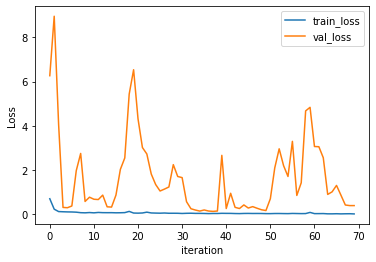

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Fine_Tuning.history['loss'], label = "train_loss")
plt.plot(history_Chest_Xaray_Classification_Fine_Tuning.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

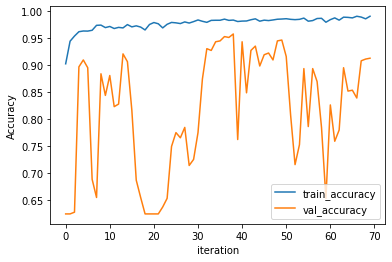

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Fine_Tuning.history['accuracy'], label = "train_accuracy")
plt.plot(history_Chest_Xaray_Classification_Fine_Tuning.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train Model With Pretrain

In [25]:
MobileNetV2_Chest_Xaray_Pretrain= MobileNetV2(pretrain=True)
MobileNetV2_Chest_Xaray_model_Pretrain = MobileNetV2_Chest_Xaray_Pretrain.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_Chest_Xaray_model_Pretrain(x)
x = layers.GlobalMaxPool2D()(x)
x = layers.Dense(units = 1028, activation= 'relu')(x)
outputs= layers.Dense(units = 2, activation= 'softmax')(x)
Chest_Xaray_Classification_Pretrain = keras.Model(inputs = image_input, outputs = outputs)
Chest_Xaray_Classification_Pretrain.summary()

train with pretrain model
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                 

In [26]:
Chest_Xaray_Classification_Pretrain.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [27]:
checkpoint_path = "Chest_Xaray_Classification_Pretrain.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
    
history_Chest_Xaray_Classification_Pretrain = Chest_Xaray_Classification_Pretrain.fit(chest_xray.train_ds,
                                epochs = EPOCHS,
                                validation_data = chest_xray.val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/70
164/164 [==============================] - ETA: 0s - loss: 0.9901 - accuracy: 0.8815
Epoch 00001: val_accuracy improved from -inf to 0.84295, saving model to Chest_Xaray_Classification_Pretrain.ckpt
164/164 [==============================] - 10s 50ms/step - loss: 0.9901 - accuracy: 0.8815 - val_loss: 0.3914 - val_accuracy: 0.8429
Epoch 2/70
163/164 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9270
Epoch 00002: val_accuracy improved from 0.84295 to 0.89103, saving model to Chest_Xaray_Classification_Pretrain.ckpt
164/164 [==============================] - 9s 48ms/step - loss: 0.2161 - accuracy: 0.9270 - val_loss: 0.2946 - val_accuracy: 0.8910
Epoch 3/70
163/164 [============================>.] - ETA: 0s - loss: 0.1831 - accuracy: 0.9300
Epoch 00003: val_accuracy did not improve from 0.89103
164/164 [==============================] - 9s 49ms/step - loss: 0.1836 - accuracy: 0.9300 - val_loss: 0.2977 - val_accuracy: 0.8878
Epoch 4/70
163/164 [=========

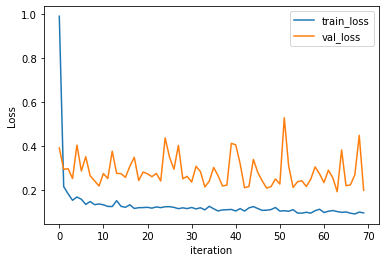

In [28]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Pretrain.history['loss'], label = "train_loss")
plt.plot(history_Chest_Xaray_Classification_Pretrain.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

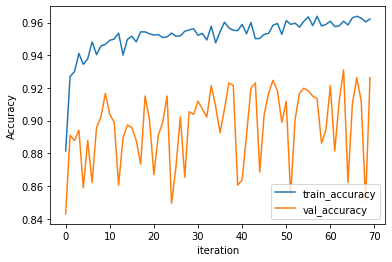

In [29]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Pretrain.history['accuracy'], label = "train_accuracy")
plt.plot(history_Chest_Xaray_Classification_Pretrain.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

#### Train Model With Initialize

In [32]:
MobileNetV2_Chest_Xaray_Initialize= MobileNetV2(Initilaize_pretrain=True)
MobileNetV2_Chest_Xaray_model_Initialize = MobileNetV2_Chest_Xaray_Initialize.create_model_MobileNetV2()

image_input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
augmentation_layers = augmentation()(image_input)
x = keras.applications.mobilenet_v2.preprocess_input(augmentation_layers)
x = MobileNetV2_Chest_Xaray_model_Initialize(x)
x = layers.GlobalMaxPool2D()(x)
outputs= layers.Dense(units = 2, activation= 'softmax')(x)
Chest_Xaray_Classification_Initialize = keras.Model(inputs = image_input, outputs = outputs)
Chest_Xaray_Classification_Initialize.summary()

train with initialize_pretrain model
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                      

In [33]:
Chest_Xaray_Classification_Initialize.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                      metrics=['accuracy'])

In [34]:
checkpoint_path = "Chest_Xaray_Classification_Initialize.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True)
    
history_Chest_Xaray_Classification_Initialize = Chest_Xaray_Classification_Initialize.fit(chest_xray.train_ds,
                                epochs = EPOCHS,
                                validation_data = chest_xray.val_ds,
                                callbacks=[model_checkpoint])

Epoch 1/70
164/164 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.9010
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to Chest_Xaray_Classification_Initialize.ckpt
164/164 [==============================] - 32s 179ms/step - loss: 0.5872 - accuracy: 0.9010 - val_loss: 12.0257 - val_accuracy: 0.6250
Epoch 2/70
164/164 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9430
Epoch 00002: val_accuracy improved from 0.62500 to 0.63942, saving model to Chest_Xaray_Classification_Initialize.ckpt
164/164 [==============================] - 30s 179ms/step - loss: 0.1827 - accuracy: 0.9430 - val_loss: 1.8464 - val_accuracy: 0.6394
Epoch 3/70
164/164 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9379
Epoch 00003: val_accuracy did not improve from 0.63942
164/164 [==============================] - 30s 177ms/step - loss: 0.1786 - accuracy: 0.9379 - val_loss: 1.5423 - val_accuracy: 0.6250
Epoch 4/70
164/164 

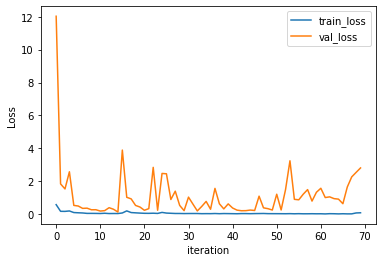

In [35]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Initialize.history['loss'], label = "train_loss")
plt.plot(history_Chest_Xaray_Classification_Initialize.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()

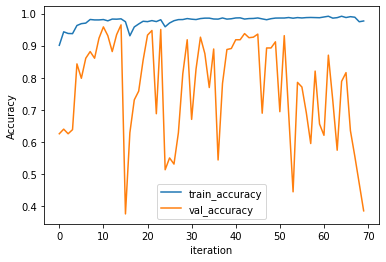

In [36]:
import matplotlib.pyplot as plt

plt.plot(history_Chest_Xaray_Classification_Initialize.history['accuracy'], label = "train_accuracy")
plt.plot(history_Chest_Xaray_Classification_Initialize.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()